In [ ]:
import numpy as np
import scipy.stats as sps
import scipy

import random as rnd

from itertools import repeat

Here we are trying to see if rank is a good way to scale data for the purposes of reducing the over-representation of high expression features.

Additionally, we're going to see if the creation of many auxiliary variables consisting of random combinations of features is going to produce results less vulnerable to scarcity issues. 

In [ ]:
counts = np.loadtxt('../raw_data/vision_sc/wolf_counts.txt')
header = np.loadtxt('../raw_data/vision_sc/wolf_gene_header.txt',dtype=str)

In [ ]:
rank_matrix = np.zeros(counts.shape)
for i,c in enumerate(counts.T):
    rank_matrix[:,i] = sps.rankdata(c,method='min')
rank_matrix = rank_matrix.T

In [ ]:
np.savetxt('./rank_aux_test/rank_matrix.txt',rank_matrix)

In [ ]:
## Here we have created a matrix with rank values instead of raw values. We would like to use minimum ranking in order to emphasize the equality of sparse features.
## This may still be biased towards higher-expression features due to dropout-expression correlation
## but it's not really a well-tractable problem.

In [ ]:
## Now let's try projecting a lot of features together. Firstly, we'd like ideally to avoid cancelling the effects of
## anticorrelated features on each other. Therefore, we'll first need a spearman's rho table. 

## There's no native implementation of spearman's rho for numpy, but spearman's rho is just the correlation of ranks,
## which we already conveniently have!

spearmans = scipy.spatial.distance.pdist(rank_matrix,metric='correlation')

In [ ]:
## I think for the first part, I'll simply pick features at random, but for each feature I add I will flip it if it
## has a negative rank correlation to aggregate. 

def rank_average(rank_matrix):
    log_rank = np.log(rank_matrix)
    geometric_mean = np.exp(np.sum(log_rank,axis=0) / rank_matrix.shape[0])
    return geometric_mean

def make_aux(rank_matrix,n):
    features = np.zeros((n,rank_matrix.shape[1]))
    feature_indecies = []
    for i in range(n):
        ci = rnd.randint(0,rank_matrix.shape[0]-1)
        features[i] = rank_matrix[ci]
        feature_indecies.append(ci)
    average_rank = np.mean(features,axis=0)
    correlations = np.array([sps.pearsonr(f,average_rank)[0] for f in features])
    flip = correlations < 0
    features[flip] = (features.shape[1] - features[flip]) * -1
    real_average = rank_average(features)
    return real_average,feature_indecies
    


In [ ]:
ar,fi = make_aux(rank_matrix,5)
print(list(ar))
print(list(fi))

In [ ]:
aux_matrix = np.zeros((counts.shape[0],2000))
aux_labels = np.zeros((2000,10))

for i in range(2000):
    aux_matrix[:,i],aux_labels[i] = make_aux(rank_matrix,10)
    
aux_labels = [",".join([str(m) for m in l]) for l in aux_labels]


In [ ]:
np.savetxt('./rank_aux_test/aux_matrix.txt',aux_matrix)
np.savetxt('./rank_aux_test/aux_labels.txt',aux_labels,fmt='%s')

In [1]:
import sys
sys.path.append("./src/")
import lumberjack
import tree_reader as tr
import tree_braider2 as trbr

In [2]:
# forest = lumberjack.fit(aux_matrix,output_counts=counts,trees=100,dispersion_mode="ssme",norm="l2",drop='none',sfr=1,in_feature_subsample=1000,out_feature_subsample=200,sample_subsample=1000,depth=10,leaves=100,ifh=aux_labels,ofh=header)
forest = tr.Forest.reconstitute('./rank_aux_test/aux_forest')

In [3]:
# forest.cluster_samples_encoding(subsample=1300,distance='cos',k=10,steps=10,verbose=True,override=True)
# forest.cluster_leaf_samples(subsample=1000,distance='cos',k=10,steps=10,verbose=True,override=True)
# forest.tsne()
# forest.plot_cell_clusters()

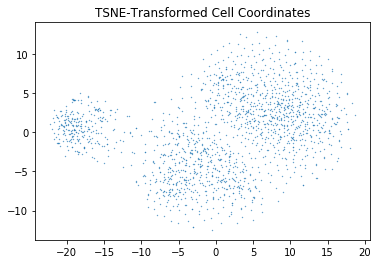

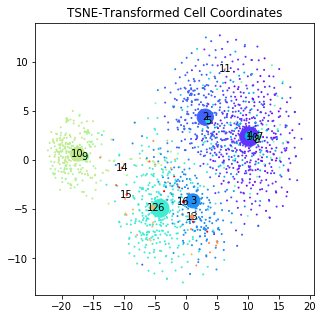

In [4]:
forest.tsne_encoding(override=True)
forest.plot_cell_clusters()

In [5]:
# forest.backup('./rank_aux_test/aux_forest')

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

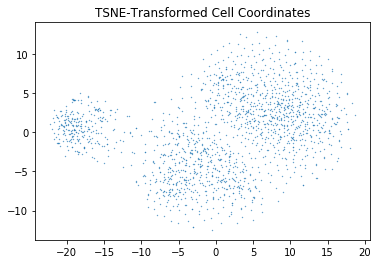

In [7]:
ttc = forest.tsne_encoding()
# ttc = TSNE().fit_transform(counts)

# plt.figure()
# plt.scatter(ttc[:,0],ttc[:,1],s=.1)
# plt.show()



In [8]:
braid = trbr.IHMM(forest,alpha_e=2,beta_e=2,start_states=100)

In [9]:
for i in range(500):
    print(i)
    print(f"beta:{braid.beta}")
    print(f"gamma:{braid.gamma}")
    print(f"states:{braid.hidden_states}")
    braid.sweep()
#     braid.max_likelihood_sweep()
#     braid.sweep()
#     if i%10 == 0:
#         braid.max_likelihood_sweep()

0
beta:1
gamma:1
states:100
Sweep debug
100
[ 0  0  0 ... 19 29 20]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29,

./src/tree_braider2.py:364: RuntimeWarning: divide by zero encountered in log2
  l2l = lambda g: (k * np.log2(g) - np.sum(log_sequence[g:oracle_total+g]))
./src/tree_braider2.py:246: RuntimeWarning: divide by zero encountered in log2
  self.state_log_odds_given_child_l = np.log2(self.state_odds_given_child_l)
./src/tree_braider2.py:247: RuntimeWarning: divide by zero encountered in log2
  self.state_log_odds_given_child_r = np.log2(self.state_odds_given_child_r)
./src/tree_braider2.py:745: RuntimeWarning: invalid value encountered in true_divide
  oracle_probability_l = (oracle_state_odds_l / (oracle_state_odds_l + direct_state_odds_l))
./src/tree_braider2.py:746: RuntimeWarning: invalid value encountered in true_divide
  oracle_probability_r = (oracle_state_odds_r / (oracle_state_odds_r + direct_state_odds_r))


Beta:45
Gamma:119
Computing state log odds | divergence
Computing oracle odds
[0. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 2. 2. 1. 2. 2. 1. 1. 2. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1.
 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 2. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 2. 1. 1.]
Sampling states
Oracle sampler debug
(101, 3094)
(101, 3094)
100
0
0
[]
(3094,)
(3094,)
(101, 3094)
(101, 3094)
(101, 3094)
(101, 3094)
1
beta:45
gamma:119
states:100
Sweep debug
100
[ 0  0  0 ... 20 72 20]
[1597, 13, 15, 16, 23, 20, 15, 16, 11, 16, 16, 16, 20, 7, 18, 12, 9, 15, 13, 12, 19, 13, 14, 15, 21, 13, 22, 10, 10, 22, 13, 10, 20, 24, 15, 15, 13, 16, 20, 25, 24, 14, 11, 16, 13, 16, 16, 10, 17, 16, 13, 12, 13, 16, 14, 18, 11, 18, 17, 24, 13, 14, 8, 12, 8, 20, 12, 5, 16, 13, 12, 9, 15, 21, 19, 18, 12, 17, 15, 14, 9, 14, 18, 13, 10, 18, 16, 19, 16, 15, 7, 18, 17, 16, 14, 14, 13, 19, 11, 25]
State Index Cl

./src/tree_braider2.py:631: RuntimeWarning: divide by zero encountered in true_divide
  transition_odds = padded_transition_counts.astype(dtype=float) / counter_odds.astype(dtype=float)
./src/tree_braider2.py:216: RuntimeWarning: invalid value encountered in multiply
  self.state_odds_given_oracle_l = self.oracle_odds_given_child_l * self.oracle_odds
./src/tree_braider2.py:217: RuntimeWarning: invalid value encountered in multiply
  self.state_odds_given_oracle_r = self.oracle_odds_given_child_r * self.oracle_odds


IndexError: boolean index did not match indexed array along dimension 0; dimension is 102 but corresponding boolean dimension is 3094

In [ ]:
plt.figure()
plt.title("(Log) State Transition Frequency,0 is Root and Leaf")
plt.imshow(np.log(braid.pad_root_transitions(braid.transition_counts).T),cmap='binary')
plt.show()
  
print(braid.state_raw_sample_odds[1])
for hidden_state in range(braid.hidden_states):
    print(np.sum(braid.state_masks[hidden_state]))
    plt.figure(figsize=(5,5))
    plt.title(f"Hidden State {hidden_state}",fontsize=20)
#     plt.scatter(iftc[:,0],iftc[:,1],c=braid.lr_finite(hidden_state),cmap='bwr')
    plt.scatter(ttc[:,0],ttc[:,1],c=braid.state_raw_sample_odds[hidden_state],s=1,cmap='PuOr')
    plt.show()
        

In [ ]:
len(forest.nodes())